In [1]:
import os
import sys

import cv2
import random
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

from transformers import SamModel, SamProcessor
from peft import get_peft_model, LoraConfig, TaskType


sys.path.append(os.path.abspath('/home/dmatveev/workdir/rosneft_segmentation/experiments'))
from prepare_data import SeismicDataset

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_2d = {
        "type": "2D",
        "seismic_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d/seismic",
        "label_dir": "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d/label",
        "shape": (224, 224),
        "mask_dtype": np.uint8,
        "augmentation_pipeline": None
    }

In [3]:
seismic_dataset = SeismicDataset(config_2d)

NameError: name 'SeismicDataset' is not defined

In [2]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def to_pil_image(np_img):
    if np_img.dtype != np.uint8:
        if np_img.max() != np_img.min():
            np_img = (255 * (np_img - np_img.min()) / (np_img.max() - np_img.min())).astype(np.uint8)
        else:
            np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)

class SegmentationDataset(Dataset):
    def __init__(self, seismic_dir, label_dir, file_list, shape=(224, 224)):
        self.seismic_dir = seismic_dir
        self.label_dir = label_dir
        self.file_list = file_list
        self.shape = shape

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        seismic_path = os.path.join(self.seismic_dir, filename)
        label_path   = os.path.join(self.label_dir, filename)
        
        seismic = load_dat_file(seismic_path, shape=self.shape)
        label   = load_dat_file(label_path, shape=self.shape)
        
        if seismic.ndim == 2:
            seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
        else:
            seismic_img = seismic
        
        pil_image = to_pil_image(seismic_img).convert("RGB")
        return filename, pil_image, label

In [3]:
def custom_collate(batch):
    return batch

In [4]:
dataset_path = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir = os.path.join(dataset_path, "seismic")
label_dir   = os.path.join(dataset_path, "label")
all_files = sorted(os.listdir(seismic_dir))

In [5]:
len(all_files)

4000

In [6]:
train_files = all_files[:3500]
val_files   = all_files[3500:]

train_dataset = SegmentationDataset(seismic_dir, label_dir, train_files, shape=(224, 224))
train_loader  = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=custom_collate)

In [9]:
zero_count = 0

for filename, pil_image, label in tqdm(train_dataset):
    if np.all(label == 0):
        zero_count += 1

print("Количество изображений, маска которых состоит полностью из 0:", zero_count)

  0%|          | 0/3500 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [02:23<00:00, 24.37it/s]

Количество изображений, маска которых состоит полностью из 0: 1373


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

In [9]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-31): 32 x SamVisionLayer(
        (layer_norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (layer_norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNor

In [10]:
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "out_proj"],  # target linear layers in attention modules
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.FEATURE_EXTRACTION  # using FEATURE_EXTRACTION for vision tasks
)
model = get_peft_model(model, lora_config)
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Trainable parameters: 94208


In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
num_epochs = 2

In [14]:
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", ncols=100)

    for batch in pbar:
        filenames, images, labels = zip(*batch)

        inputs = processor(list(images), return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}

        image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
        
        batch_prompts = []
        for label in labels:
            h, w = label.shape
            nonzero_indices = np.argwhere(label != 0)
            if len(nonzero_indices) > 0:
                idx = random.randint(0, len(nonzero_indices) - 1)
                y, x = nonzero_indices[idx]
                prompt_point = [[x, y]]
            else:
                prompt_point = [[w / 2.0, h / 2.0]]
            batch_prompts.append(prompt_point)
        
        prompt_inputs = processor(list(images), input_points=batch_prompts, return_tensors="pt")
        prompt_inputs = {k: v.to(device) for k, v in prompt_inputs.items()}
        prompt_inputs.pop("pixel_values", None)  # remove pixel_values because we use our computed embeddings
        prompt_inputs.update({"image_embeddings": image_embeddings})
        
        outputs = model(**prompt_inputs)
        
        pred_masks = outputs.pred_masks
        
        # Check dimension of pred_masks:
        if pred_masks.ndim == 5:
            # Shape: [B, 1, M, H, W]. Reduce over the candidate mask dimension (dim=2)
            pred_logits, _ = pred_masks.max(dim=2)  # shape: [B, 1, H, W]
            pred_logits = pred_logits.squeeze(1)      # shape: [B, H, W]
        elif pred_masks.ndim == 4:
            # Standard case: [B, M, H, W]
            pred_logits, _ = pred_masks.max(dim=1)     # shape: [B, H, W]
        elif pred_masks.ndim == 3:
            # Single sample case: [M, H, W]
            pred_logits, _ = pred_masks.max(dim=0)     # shape: [H, W]
            pred_logits = pred_logits.unsqueeze(0)     # add batch dimension -> [1, H, W]
        else:
            raise ValueError(f"Unexpected pred_masks shape: {pred_masks.shape}")
        
        
        # Prepare ground truth masks.
        gt_masks = [torch.tensor(label, device=device).float() for label in labels]  # each: [H, W]
        gt_masks = torch.stack(gt_masks, dim=0)  # shape: [B, H, W]
        # tqdm.write(f"gt_masks shape: {gt_masks.shape}")
        
        # If needed, interpolate predicted logits to match ground truth spatial dimensions.
        if pred_logits.shape[-2:] != gt_masks.shape[-2:]:
            pred_logits = F.interpolate(pred_logits.unsqueeze(1), size=gt_masks.shape[-2:], mode="bilinear", align_corners=False).squeeze(1)
            # tqdm.write(f"After interpolation, pred_logits shape: {pred_logits.shape}")
        
        # Compute binary cross-entropy loss on the logits.
        loss = F.binary_cross_entropy_with_logits(pred_logits, gt_masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")

Epoch 1:  87%|█████████████████████████████████▊     | 759/875 [35:20<05:24,  2.79s/it, loss=0.1644]


KeyboardInterrupt: 

# test

In [15]:
def load_dat_file(filepath, shape=(224, 224)):
    data = np.fromfile(filepath, dtype=np.float32)
    return data.reshape(shape)

def to_pil_image(np_img):
    if np_img.dtype != np.uint8:
        if np_img.max() != np_img.min():
            np_img = (255 * (np_img - np_img.min()) / (np_img.max() - np_img.min())).astype(np.uint8)
        else:
            np_img = np_img.astype(np.uint8)
    return Image.fromarray(np_img)

def compute_metrics(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).astype(np.uint8)
    target_bin = (target > threshold).astype(np.uint8)
    
    if pred_bin.sum() == 0 and target_bin.sum() == 0:
        return 1.0, 1.0

    intersection = np.logical_and(pred_bin, target_bin).sum()
    union = np.logical_or(pred_bin, target_bin).sum()
    iou = intersection / union if union != 0 else 0.0

    pred_sum = pred_bin.sum()
    target_sum = target_bin.sum()
    dice = (2.0 * intersection) / (pred_sum + target_sum) if (pred_sum + target_sum) != 0 else 0.0

    return iou, dice

In [16]:
dataset_path_test_temp = "/home/dmatveev/workdir/rosneft_segmentation/data/Salt2d"
seismic_dir_test_temp = os.path.join(dataset_path_test_temp, "seismic")
label_dir_test_temp   = os.path.join(dataset_path_test_temp, "label")
all_files_test_temp = sorted(os.listdir(seismic_dir_test_temp))
val_files_test_temp = all_files_test_temp[:10]

In [17]:
def display_four_images(image, gt_mask, pred_mask, threshold=0.5):
    """
    Отображает 4 изображения:
      1. Исходное изображение.
      2. Исходное изображение с отмеченной случайной точкой (из ground truth маски).
      3. Ground truth маску (в оттенках серого).
      4. Предсказанную маску (в оттенках серого).
      
    Args:
      image: PIL.Image (RGB).
      gt_mask: 2D numpy array с ground truth маской.
      pred_mask: 2D numpy array с предсказанной моделью маской.
      threshold: порог для определения положительных пикселей.
    """
    if isinstance(image, Image.Image):
        img_np = np.array(image)
    else:
        img_np = image.copy()
    
    pos_indices = np.argwhere(gt_mask > threshold)
    if len(pos_indices) == 0:
        h, w = gt_mask.shape
        point = [h // 2, w // 2]
    else:
        point = random.choice(pos_indices)  # (row, col)
    
    # Построение 4-х изображений
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 1. Исходное изображение
    axes[0].imshow(img_np)
    axes[0].set_title("Исходное")
    axes[0].axis("off")
    
    # 2. Исходное изображение с отмеченной точкой
    axes[1].imshow(img_np)
    axes[1].scatter(point[1], point[0], color="green", marker="o", s=100)
    axes[1].set_title("С точкой (ground truth)")
    axes[1].axis("off")
    
    # 3. Ground truth маска
    axes[2].imshow(gt_mask, cmap="gray")
    axes[2].set_title("Ground Truth Маска")
    axes[2].axis("off")
    
    # 4. Предсказанная маска
    axes[3].imshow(pred_mask, cmap="gray")
    axes[3].set_title("Предсказанная Маска")
    axes[3].axis("off")
    
    plt.tight_layout()
    plt.show()


In [25]:
val_files_test_temp

'1005.dat'

/home/dmatveev/workdir/rosneft_segmentation/for_rosneft/lib/python3.11/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


outputs - 
SamImageSegmentationOutput(iou_scores=tensor([[[0.5877, 0.7477, 0.7307]]], device='cuda:0'), pred_masks=tensor([[[[[ 0.0847,  1.1293,  0.7474,  ...,  0.8964,  0.2371,  0.6624],
           [ 0.2226,  0.3137,  0.7444,  ...,  0.2546,  0.1149, -0.1126],
           [ 0.0693,  2.0386,  0.4808,  ...,  0.9939, -0.4841,  0.4035],
           ...,
           [-1.2382, -0.4511,  0.1825,  ..., -1.3172, -1.1900, -1.8491],
           [-1.7066, -0.1570, -0.9114,  ..., -0.9191, -1.8426, -0.9979],
           [-0.8484, -0.2425,  0.2847,  ..., -1.2849, -0.8404, -1.4016]],

          [[ 2.4768,  3.7232,  4.0659,  ...,  2.5601,  2.6442,  2.9425],
           [ 3.5887,  5.4582,  5.8843,  ...,  4.7790,  5.2859,  5.0949],
           [ 3.9117,  6.1964,  6.2817,  ...,  4.4389,  4.0586,  4.1478],
           ...,
           [ 0.2238,  1.7514,  2.4040,  ..., -0.8461, -0.7276, -1.2713],
           [ 0.6386,  2.2053,  2.0379,  ..., -0.7777, -1.1101, -1.4506],
           [ 0.5637,  2.3633,  1.8286,  ..., -0.

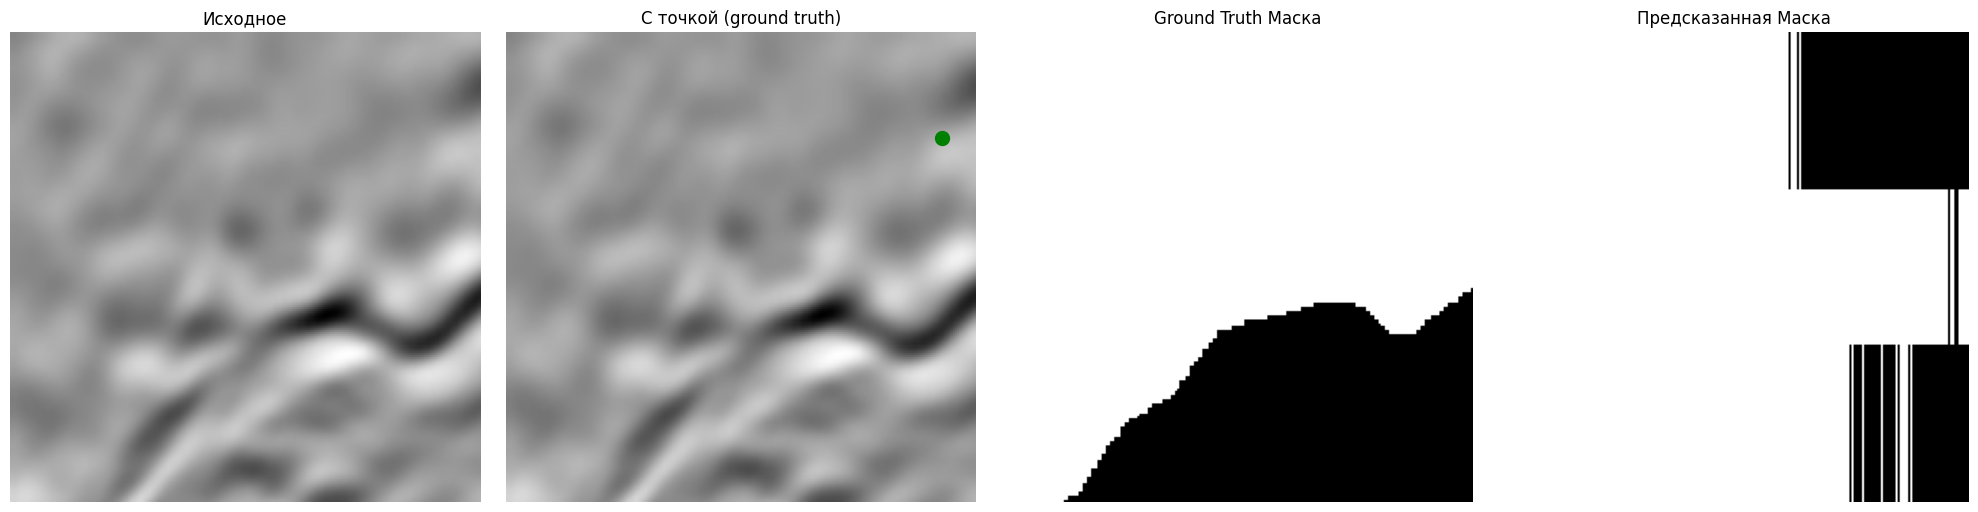

In [29]:
ious = []
dices = []

for filename in val_files_test_temp[-1:]:
    seismic_path = os.path.join(seismic_dir_test_temp, filename)
    label_path   = os.path.join(label_dir_test_temp, filename)  # Предполагается совпадение имён

    seismic = load_dat_file(seismic_path)
    label   = load_dat_file(label_path)

    # Если изображение одноканальное, создаём 3-канальное
    if seismic.ndim == 2:
        seismic_img = np.stack([seismic, seismic, seismic], axis=-1)
    else:
        seismic_img = seismic

    pil_image = to_pil_image(seismic_img).convert("RGB")

    # ---------------------------
    # Предсказание маски моделью SAM
    # ---------------------------
    # 1. Вычисление эмбеддингов изображения
    emb_inputs = processor(pil_image, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(emb_inputs["pixel_values"])
    
    # 2. Подготовка prompt: выбираем случайную точку из ground truth маски
    pos_indices = np.argwhere(label > 0)
    if len(pos_indices) > 0:
        chosen_idx = random.choice(pos_indices)
        # SAM ожидает координаты (x, y) = (столбец, строка)
        prompt_point = [[float(chosen_idx[1]), float(chosen_idx[0])]]
    else:
        h, w = label.shape
        prompt_point = [[w / 2.0, h / 2.0]]
    input_points = [prompt_point]

    # 3. Подготовка входных данных с prompt
    inputs = processor(pil_image, input_points=input_points, return_tensors="pt").to(device)
    inputs.pop("pixel_values", None)  # удаляем, чтобы заменить эмбеддингами
    inputs.update({"image_embeddings": image_embeddings})

    # 4. Инференс модели
    with torch.no_grad():
        outputs = model(**inputs)
    
    print("outputs - ", outputs, sep="\n")

    # 5. Постобработка предсказанных масок
    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )
    print("masks - ", masks, sep="\n")
    if len(masks) > 0 and len(masks[0]) > 0:
        pred_mask = masks[0][0]
        if isinstance(pred_mask, torch.Tensor):
            pred_mask = pred_mask.cpu().numpy()
        # Выводим оригинальную форму для отладки
        # print("Оригинальная форма pred_mask:", pred_mask.shape)
        pred_mask = np.squeeze(pred_mask)
        # Если после squeeze осталась 3D маска (например, (H, W, C)), берем первый канал.
        if pred_mask.ndim == 3 and pred_mask.shape[2] > 1:
            pred_mask = pred_mask[..., 0]
    else:
        pred_mask = np.zeros(label.shape, dtype=np.uint8)
    
    # Если форма предсказанной маски не совпадает с формой label, приводим её к нужному размеру.
    if pred_mask.shape != label.shape:
        pred_mask = cv2.resize(pred_mask.astype(np.uint8), (label.shape[1], label.shape[0]))
    
    # Вычисление метрик
    iou, dice = compute_metrics(pred_mask, label)
    ious.append(iou)
    dices.append(dice)
    print(f"File: {filename}, IoU: {iou:.4f}, Dice: {dice:.4f}")

    # ---------------------------
    # Отображение 4 изображений: исходное, с точкой, с overlay и маска.
    # ---------------------------
    display_four_images(pil_image, label, pred_mask)

In [22]:
sum(dices)/len(dices)

np.float64(0.47373397703091175)